# This spread sheet uses surface temperaturue measurements along with Other met and canopy variables and estimates of Rn G to give estimates of ET and compares with measurements

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import MathsUtilities as MUte

## Bring in data

### Bring in the cover Data

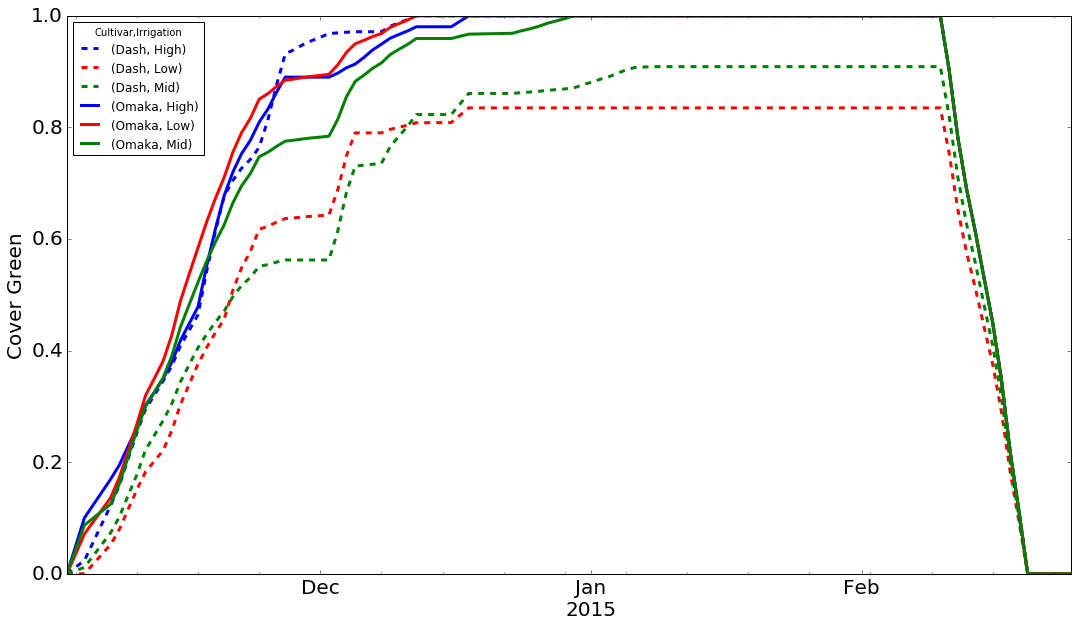

In [2]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

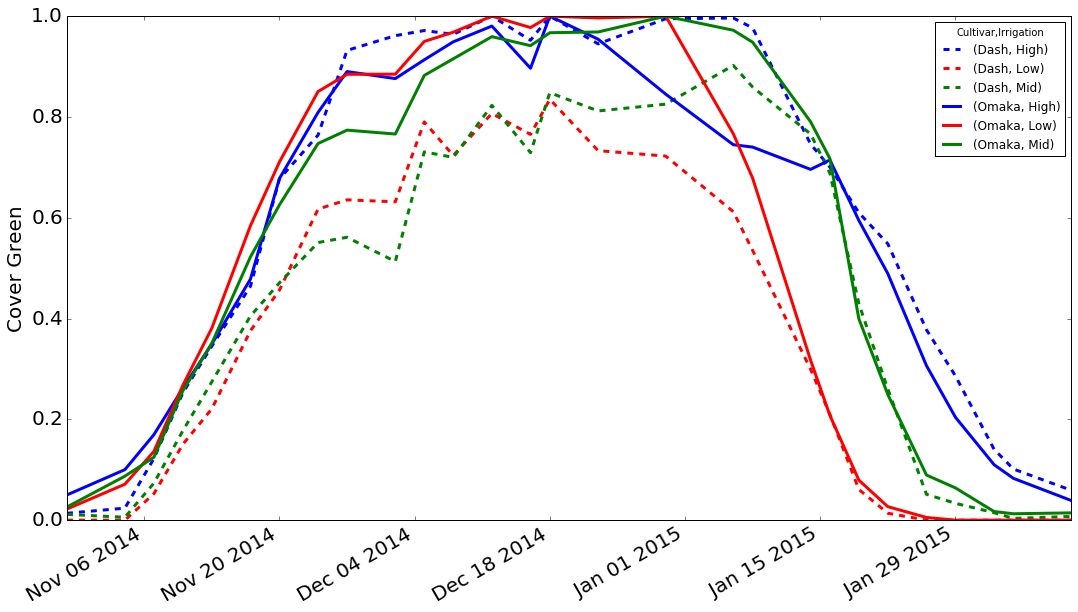

In [3]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

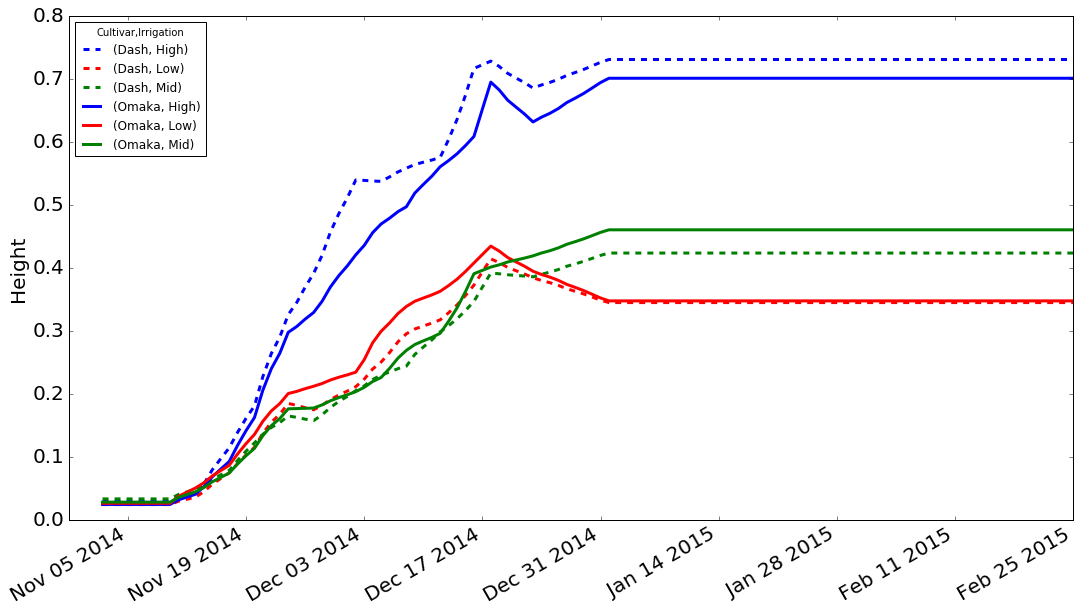

In [4]:
HeightData = pd.read_pickle('.\DataFrames\HeightEstimated.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Height', fontsize = 20)

## Bring in the Energy Balance Data

In [5]:
EstRn = pd.read_pickle('.\DataFrames\EstNetRadiation.pkl')
EstG= pd.read_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl')
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
TnRData.index.name='Date'
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
TsULTa = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
TsLLTa = pd.read_pickle('.\DataFrames\TsTaLLDF.pkl')
Ra = pd.read_pickle('.\DataFrames\RaDF.pkl')
ECT = '2014-11-08 00:00:00'
LCT = '2015-02-11 00:00:00'

Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1.013 #Heat capacity of air kJoule/kg/oC

##Contract dataframes down to common index size
TnRData = TnRData.ix[ECT:LCT,:]

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

## Do some processing and cleaning

In [6]:
#Create a list of time to exclude where data was missing or irrigation was applied
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']

ExclusionDates = IrrigationDates
for Date in NoMeasurementDates:
    ExclusionDates.append(Date)

#Exclude data from Temperature and radiation dataframe
ExclusionDateTimes5 = []
for Date in ExclusionDates:
    ExclusionDateTimes5 += pd.date_range(Date,periods=288,freq='5T')
TnRData = TnRData.ix[~TnRData.index.isin(ExclusionDateTimes5)]

# Make an index of all daylight hours in trial
HourlyTnRDataSum = TnRData.resample('h').sum()
HourlyTnRDataMean = TnRData.resample('h').mean()
DaylightIndex = HourlyTnRDataSum.ix[:,'IncomingRadnMJ'].where(HourlyTnRDataSum.ix[:,'IncomingRadnMJ']>0.02)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.to_datetime()

# Make day time means and sums for temperature and radiation data
DayTimeTnRDataMean = HourlyTnRDataMean.ix[DaylightIndex].resample('d').mean()
DayTimeTnRDataSum = HourlyTnRDataSum.ix[DaylightIndex].resample('d').sum()

# Make daily (day time) ET dataframe from hourly data excluding dark periods
ET = HourlyWateruse.ix[DaylightIndex].resample('d').sum()
ET = ET.ix[~ET.index.isin(ExclusionDates)]
ET = ET*-1
ET.index.name = 'Date'
ET.columns = ET.columns.swaplevel('Irrigation','Cultivar')

#Exclude non measurement and irrigation dates from Rn and G data frames
EstRn = EstRn.ix[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.ix[~EstG.index.isin(ExclusionDates)]

#Exclude data from Surface Temperature upper limit dataframe and make daily mean
TsULTa = TsULTa.ix[~TsULTa.index.isin(ExclusionDateTimes5)]
TsLLTa = TsLLTa.ix[~TsLLTa.index.isin(ExclusionDateTimes5)]
HourlyTsULTa = TsULTa.resample('h').mean()
HourlyTsLLTa = TsLLTa.resample('h').mean()
DayTimeTsULTaMean = TsULTa.ix[DaylightIndex].resample('d').mean()
DayTimeTsLLTaMean = TsLLTa.ix[DaylightIndex].resample('d').mean()

#Exclude data from aerodynamic resistance dataframe and make daily mean
Ra = Ra.ix[~Ra.index.isin(ExclusionDateTimes5)]
HourlyRa = Ra.resample('h').mean()
DayTimeRaMean = Ra.ix[DaylightIndex].resample('d').mean()

In [7]:
LAI = [0,0.33,0.66,1.0,1.33,1.66,2.0,2.33,2.66,3.0,3.33,3.66,4.0,4.33,4.66,5,5.33,5.66,6.0,6.33,6.66,7.0,7.33,7.66,8.0,8.33,8.66,9.0,9.33,9.66,10.0]


In [8]:
def makeSeries(Var,Frame):
    SSeries= Frame.ix[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [9]:
import math as math #import library for math functions
def RaZot(WindSpeed, Zu, h):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 3.0:
        WindSpeed = 3
    d = (0.63*h)  # is the zero displacement height which is a complex function of canopy height and archicture
    Zom = (0.13*h) * 0.2  # is the roughness length of momenum and is also influenced by canopy height and archicture
    LN = math.log((Zu-d)/Zom)
    _ret = 4.72*math.pow(LN,2)/(1+0.54*WindSpeed)
    _ret
    return _ret

In [10]:
def RsfromCover(Cover,Ext):
    Cover = min(Cover,0.99)
    factor = -Ext/1.28
    return 300 * factor/np.log(1-Cover)

(0, 900)

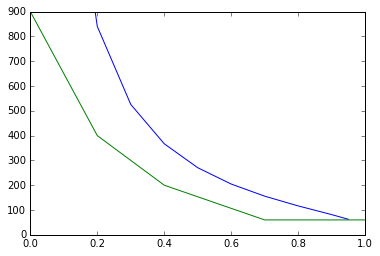

In [11]:
covers = [0.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,0.95]
Rss = [RsfromCover(x,.8) for x in covers]
plt.plot(covers,Rss)
plt.plot([0,0.2,0.4,0.7,1],[900,400,200,60,60])
plt.ylim(0,900)

In [12]:
EstEnergyBalance.ix[:,'RaZom'].plot()

NameError: name 'EstEnergyBalance' is not defined

In [13]:
plt.plot(EstEnergyBalance.ix[:,'RaZot'],EstEnergyBalance.ix[:,'RaZom'],'o')
plt.ylabel('RaZom')
plt.xlabel('RaZot')
plt.plot([0,90],[0,90])

NameError: name 'EstEnergyBalance' is not defined

In [14]:
def ExtinctionCoeff(Cult):
    ret = 0.6
    if Cult == 'Dash':
        ret = 0.8
    return ret
        

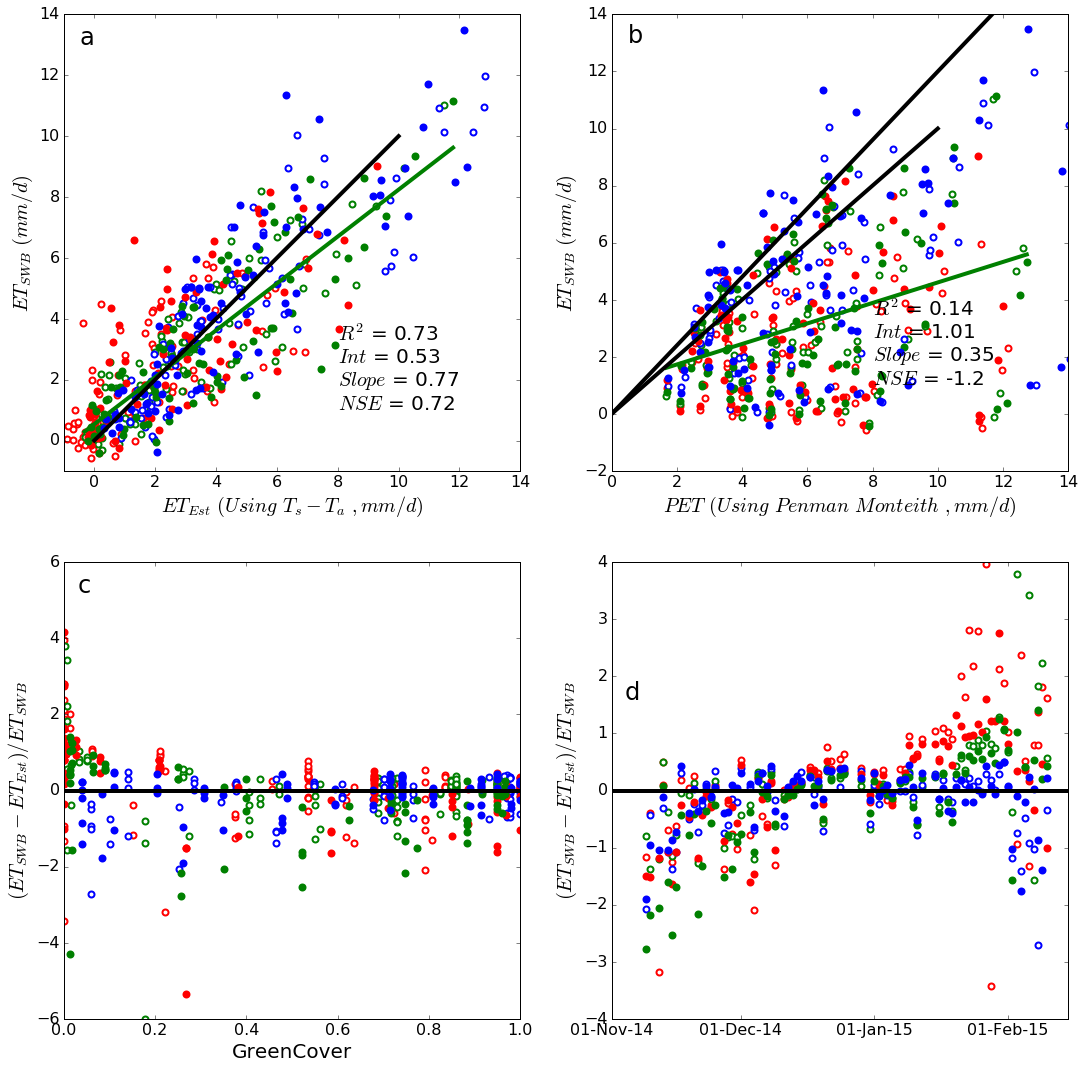

In [30]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.ix[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.ix[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Make surface temperature limit data long and join into energy balance data frame
DayTimeTsULTaMean.index.name = 'Date'
TsULTaLong = DayTimeTsULTaMean.unstack()
TsULTaLong.name = 'TsUL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsULTaLong)
DayTimeTsLLTaMean.index.name = 'Date'
TsLLTaLong = DayTimeTsLLTaMean.unstack()
TsLLTaLong.name = 'TsLL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsLLTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.ix[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.ix[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
VPSeries = makeSeries('VP',TnRDataLong)
for plot in PlotList:
    #Hourly Water use in mm is equal to kg/m2 need to multiply by latent heat of vapourisation to convert to MJ
    EstEnergyBalance.ix[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.ix[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.ix[plot,'u'] = windSeries.values
    EstEnergyBalance.ix[plot,'q'] = qSeries.values
    EstEnergyBalance.ix[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.ix[plot,'Ea'] = VPSeries.values
    EstEnergyBalance.ix[plot,'PET'] = DayTimePET[EstEnergyBalance.ix[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.ix[:,'Cover'] = CoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'GreenCover'] = GreenCoverData.ix[DateSet].bfill().unstack()
EstEnergyBalance.ix[:,'Height'] = HeightData.ix[DateSet].bfill().unstack()
    
#Calculate some other values    
EstEnergyBalance.ix[:,'qCp'] = EstEnergyBalance.ix[:,'q'] * Cp
#EstEnergyBalance.ix[:,'uVPD'] = EstEnergyBalance.ix[:,'u'] * EstEnergyBalance.ix[:,'VPD']
#EstEnergyBalance.ix[:,'Ts-TaqCp'] = EstEnergyBalance.ix[:,'Ts-Ta'] * EstEnergyBalance.ix[:,'q'] * Cp
EstEnergyBalance.ix[:,'EstRn-EstG'] = EstEnergyBalance.ix[:,'EstRn'] - EstEnergyBalance.ix[:,'EstG']

EstEnergyBalance.ix[:,'Ts'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'Ts-Ta']
EstEnergyBalance.ix[:,'To'] = EstEnergyBalance.ix[:,'Ts']  + 0 + EstEnergyBalance.ix[:,'VPD'] * 1
EstEnergyBalance.ix[:,'To-Ta'] =  EstEnergyBalance.ix[:,'To'] -  EstEnergyBalance.ix[:,'Ta'] 
#EstEnergyBalance.ix[:,'TsUL'] = EstEnergyBalance.ix[:,'Ta'] + EstEnergyBalance.ix[:,'TsUL-Ta']
#EstEnergyBalance.ix[:,'ToUL'] = EstEnergyBalance.ix[:,'TsUL'] + 0 +  EstEnergyBalance.ix[:,'VPD'] * 1
#EstEnergyBalance.ix[:,'ToUL-Ta'] = EstEnergyBalance.ix[:,'ToUL'] - EstEnergyBalance.ix[:,'Ta']
#EstEnergyBalance.ix[:,'(To-Ta)/(ToUL-Ta)'] = EstEnergyBalance.ix[:,'To-Ta']/EstEnergyBalance.ix[:,'ToUL-Ta']
#EstEnergyBalance.ix[:,'(To-Ta)qCp'] = EstEnergyBalance.ix[:,'To-Ta'] * EstEnergyBalance.ix[:,'qCp']

#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)

#Find maximum daily values for ET and To across the experiment to use as potentials
PotVars = ['ET','To']
PotVarFilter = EstEnergyBalance.columns.isin(PotVars)
TreatMeans = EstEnergyBalance.ix[:,PotVarFilter].groupby(level = ['Cultivar','Irrigation','Date']).mean()
for plot in PlotList:
    EstEnergyBalance.ix[plot,'PotET'] = TreatMeans.ix[:,'ET'].groupby(level='Date').max().values
    EstEnergyBalance.ix[plot,'PotTo'] = TreatMeans.ix[:,'To'].groupby(level='Date').min().values


IntIndex = range(EstEnergyBalance.index.size)

# GCov = [0,0.4,0.7,1]   
# Rs = [700,200,60,60]
# EstEnergyBalance.ix[:,'Rs'] = [np.interp(EstEnergyBalance.ix[x,'GreenCover'],GCov,Rs) for x in IntIndex]
#EstEnergyBalance.ix[:,'EqEvap'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],EstEnergyBalance.ix[x,'Ta'],1,'net') for x in IntIndex]
EstEnergyBalance.ix[:,'ExtCoeff'] = [ExtinctionCoeff(EstEnergyBalance.ix[x,:].name[0]) for x in IntIndex]
EstEnergyBalance.ix[:,'Rs'] = [RsfromCover(EstEnergyBalance.ix[x,'GreenCover'],EstEnergyBalance.ix[x,'ExtCoeff']) for x in IntIndex]
EstEnergyBalance.ix[:,'PrystTay'] = [et.Priestly_TaylorEO(EstEnergyBalance.ix[x,'EstRn-EstG'],
                                                          EstEnergyBalance.ix[x,'Ta'],
                                                          1.23,'net') for x in IntIndex]
EstEnergyBalance.ix[:,'PenEvap'] = [et.PenmanEO(EstEnergyBalance.ix[x,'EstRn-EstG'],
                                                EstEnergyBalance.ix[x,'Ta'],
                                                EstEnergyBalance.ix[x,'u'],
                                                EstEnergyBalance.ix[x,'Ea'],
                                                'net') for x in IntIndex]
EstEnergyBalance.ix[:,'RaZot'] = [RaZot(EstEnergyBalance.ix[x,'u'],
                                  1.2, 
                                  EstEnergyBalance.ix[x,'Height']) for x in IntIndex]
EstEnergyBalance.ix[:,'RaZom'] = [et.Ra(EstEnergyBalance.ix[x,'u'],
                                  1.2, 
                                  EstEnergyBalance.ix[x,'Height'])for x in IntIndex]
EstEnergyBalance.ix[:,'qCP/Ra'] = EstEnergyBalance.ix[:,'qCp']/(EstEnergyBalance.ix[:,'RaZot']/10)
EstEnergyBalance.ix[:,'SatVP'] = [et.saturated_vapor_pressure(EstEnergyBalance.ix[x,'Ta'])/10 for x in IntIndex]
EstEnergyBalance.ix[:,'To-PotTo'] = EstEnergyBalance.ix[:,'To'] - EstEnergyBalance.ix[:,'PotTo']
EstEnergyBalance.ix[:,'Delta'] = EstEnergyBalance.ix[:,'qCP/Ra'] * EstEnergyBalance.ix[:,'To-PotTo']
EstEnergyBalance.ix[:,'RH'] = np.divide(EstEnergyBalance.ix[:,'Ea'],EstEnergyBalance.ix[:,'SatVP'])
EstEnergyBalance.ix[:,'RH'] = np.multiply(EstEnergyBalance.ix[:,'RH'],100)
EstEnergyBalance.ix[:,'PenMon'] = [et.PenmanMonteith(EstEnergyBalance.ix[x,'EstRn-EstG'],
                                                     EstEnergyBalance.ix[x,'Ta'],
                                                     EstEnergyBalance.ix[x,'RH'],
                                                     EstEnergyBalance.ix[x,'u'],
                                                     EstEnergyBalance.ix[x,'RaZom'],
                                                     70,
                                                     86400) for x in IntIndex]
GCov = [0,0.7,1]   
CovFact = [0.1,1,1]
EstEnergyBalance.ix[:,'CovFact'] = [np.interp(EstEnergyBalance.ix[x,'GreenCover'],GCov,CovFact) for x in IntIndex]
EstEnergyBalance.ix[:,'EstET'] = (EstEnergyBalance.ix[:,'PenMon']*EstEnergyBalance.ix[:,'CovFact']) - EstEnergyBalance.ix[:,'Delta']
    
#Calculate residual
EstEnergyBalance.ix[:,'ResidualET'] = EstEnergyBalance.ix[:,'ET'] - EstEnergyBalance.ix[:,'EstET']

#make a dataframe with treatment means
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()

makegraph()
MakeCumGraph()

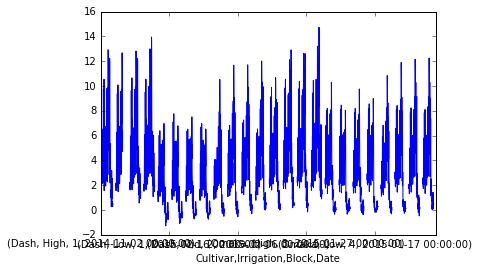

In [27]:
EstEnergyBalance.ix[:,'EstET'].plot()

In [28]:
def MakeCumGraph():
    graph = plt.figure(figsize=(18,10))
    start = '2014-10-1'
    end = '2015-03-15'
    pos = 1
    for Irr in Irrigations:
        line = '-'
        for Cul in Cultivars:
            Pannel = graph.add_subplot(3,2,pos)    
            Data = EBMeans.ix[(Cul,Irr),:]
            plt.plot(Data.ix[start:end,'ET'].cumsum(),label = 'ET',linewidth = 2,color='b')
            plt.plot(Data.ix[start:end,'EstET'].cumsum(),label = 'EstET',linewidth = 2,color='r')
            plt.plot(Data.ix[start:end,'PenEvap'].cumsum(),'--',label='PenEvap',linewidth = 2,color='g')
            plt.plot(Data.ix[start:end,'PrystTay'].cumsum(),'-.',label='PrystlyT',linewidth = 2,color='g')
            plt.plot(Data.ix[start:end,'PenMon'].cumsum(),label='PenMon',linewidth = 2,color='g')
            #diff = Data.ix[start:end,'EstET'].cumsum() - Data.ix[start:end,'ET'].cumsum()
            #plt.plot(diff,linewidth = 2)
            plt.ylim(-50,400)
            plt.text('2014-11-15',350,Irr + ' ' + Cul,fontsize=16)
            line = '--'
            if pos == 1:
                plt.legend(loc=1)
            pos +=1

In [29]:
def makegraph():
    Colors = ['red', 'green', 'blue']
    Markerfills = ['white','white','white','red', 'green', 'blue']
    culpos = 0
    Comparison = plt.figure(figsize = (18,18))
    fig = Comparison.add_subplot(2,2,1)
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigations:
            Y = EBMeans.ix[(cul,irr),'ET']#.ix['2014-11-16':'2015-01-15']
            X = EBMeans.ix[(cul,irr),'EstET']#.ix['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low reatments
    ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.ix[ValidationFilter,'EstET'] 
    Y = EBMeans.ix[ValidationFilter,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    plt.plot(Xs,Ys,'-', linewidth = 4, color='g')
    plt.plot([0,10],[0,10],'-', linewidth = 4, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
        + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(8,1.,fitR2,fontsize=20)        
    plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
    plt.xlabel(r'$ET_{Est}$ $(Using$ $T_s-T_a$ $,mm/d)$',fontsize=20)
    plt.tick_params(labelsize=16)
    plt.text(-0.5,13,'a',fontsize=24)
    plt.xlim(-1,14)
    plt.ylim(-1,14)



    fig = Comparison.add_subplot(2,2,2)
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigations:
            Y = EBMeans.ix[(cul,irr),'ET']
            #X = DayTimePET.ix[Y.index]
            X = EBMeans.ix[(cul,irr),'PenMon']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos+=1
            culpos+=1
    plt.plot([0,12],[0,14.4],'-', linewidth = 4, color='k')
    plt.xlabel('$PET$ $(Using$ $Penman$ $Monteith$ $,mm/d)$',fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylim(-2,14)
    plt.text(0.5,13,'b',fontsize=24)
    ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.ix[ValidationFilter,'PenMon'] 
    Y = EBMeans.ix[ValidationFilter,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    plt.plot(Xs,Ys,'-', linewidth = 4, color='g')
    plt.plot([0,10],[0,10],'-', linewidth = 4, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
        + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(8,1.,fitR2,fontsize=20) 
    plt.ylabel('$ET_{SWB}$ $(mm/d)$',fontsize=20)
    #plt.legend(['Low Dash','Mid Dash','High Dash','Low Omaka','Mid Omaka','High Omaka'],loc=[-1.25,1.05],ncol=6,fontsize=18)
    #plt.text(-8,16.5,'Irrigation level and cultivar treatments',fontsize=24)
    plt.xlim(0,14)


    fig = Comparison.add_subplot(2,2,3)
    culpos = 0
    for Cultivar in Cultivars:
        irrpos = 0 
        for Irrigation in Irrigations:
            yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
            yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
            xData = EstEnergyBalance.ix[(Cultivar,Irrigation),'GreenCover'].groupby(level='Date',axis=0).mean()
            plt.plot(xData,yData/yObs, 'o',  mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos += 1
            culpos +=1
    plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
    plt.xlabel('GreenCover',fontsize=20)
    plt.tick_params(labelsize = 16)
    plt.text(0.03,5.2,'c',fontsize=24)
    plt.ylim(-6,6)
    plt.plot([0,1],[0,0],'-', linewidth = 4, color='k')

    fig = Comparison.add_subplot(2,2,4)
    culpos = 0
    for Cultivar in Cultivars:
        irrpos = 0  
        for Irrigation in Irrigations:
            yData = EstEnergyBalance.ix[(Cultivar,Irrigation),'ResidualET'].groupby(level='Date',axis=0).mean()
            yObs = EstEnergyBalance.ix[(Cultivar,Irrigation),'ET'].groupby(level='Date',axis=0).mean()
            xData = yData.index
            plt.plot(xData,yData/yObs, 'o', mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos += 1
            culpos +=1
        plt.ylabel('$(ET_{SWB}-ET_{Est})/ET_{SWB}$', fontsize= 20)
    plt.xlim('2014-11-1','2015-02-15')
    fig.xaxis.set_major_locator(mdates.MonthLocator())
    fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
    plt.tick_params(labelsize=16)
    plt.text('2014-11-4',1.6,'d',fontsize=24)
    plt.ylim(-4,4)
    plt.plot(['2014-11-1','2015-02-15'],[0,0],'-', linewidth = 4, color='k')